In [222]:
using DelimitedFiles
using Plots
using Random
using JLD2
using StatsBase
using Normalization

In [223]:
X_train = readdlm("/Users/joshua/Documents/QuantumInspiredML/LogLossAlternative/generative_experiment/cardiac_arrhythmia/sleep_X_train.txt");
y_train = readdlm("/Users/joshua/Documents/QuantumInspiredML/LogLossAlternative/generative_experiment/cardiac_arrhythmia/sleep_y_train.txt");
X_test = readdlm("/Users/joshua/Documents/QuantumInspiredML/LogLossAlternative/generative_experiment/cardiac_arrhythmia/sleep_X_test.txt");
y_test = readdlm("/Users/joshua/Documents/QuantumInspiredML/LogLossAlternative/generative_experiment/cardiac_arrhythmia/sleep_y_test.txt");

In [224]:
y_train = Int.(y_train);
y_test = Int.(y_test);

# Inspect the dataset

Recall that:
1. Wake (13.84% in train and 4.05% in test)
2. Non rapid eye movement type 1 (6.56% in train and 10.98% in test)
3. Non rapid eye movement type 2 (42.73% in train and 48.93% in test)
4. Non rapid eye movement type 3 (15.81% in train and 18.82% in test)
5. Rapid Eye Movement (21.06% in train and 18.82% in test)

In [225]:
countmap(y_train)

Dict{Int64, Int64} with 5 entries:
  0 => 55095
  4 => 100200
  2 => 222795
  3 => 68550
  1 => 32145

Let's turn this into a simple binary classification problem: NREM Stage 2 versus NREM Stage 3. We will start by extracting the classes of interest (0 and 4).

In [226]:
nrem2_idxs = findall(x -> x .== 2, y_train[:, 1]);
nrem3_idxs = findall(x -> x .== 3, y_train[:, 1]);
nrem2_samples = X_train[nrem2_idxs, :];
nrem3_samples = X_train[nrem3_idxs, :];

Plot some examples of the raw data

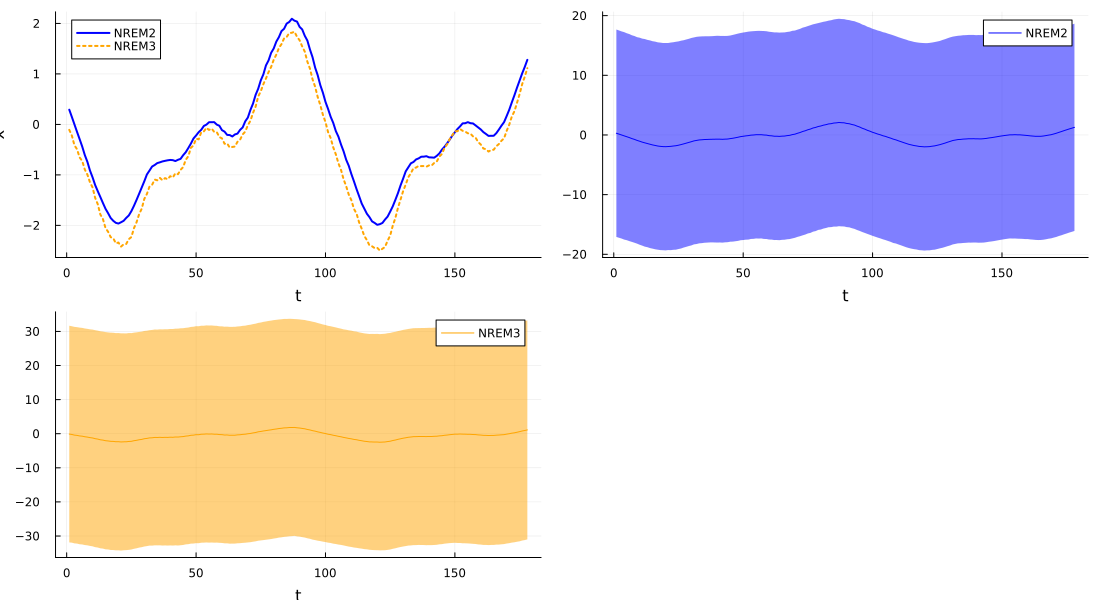

In [227]:
nrem2_mean = mean(nrem2_samples, dims=1)[1,:]
nrem2_std = std(nrem2_samples, dims=1)[1,:]
nrem3_mean = mean(nrem3_samples, dims=1)[1,:]
nrem3_std = std(nrem3_samples, dims=1)[1,:]
p1 = plot(nrem2_mean, xlabel="t", ylabel="x", label="NREM2", lw=2, c=:blue)
plot!(nrem3_mean, xlabel="t", ylabel="x", label="NREM3", lw=2, ls=:dot, c=:orange)
p2 = plot(nrem2_mean, ribbon=nrem2_std, xlabel="t", label="NREM2", c=:blue)
p3 = plot(nrem3_mean, ribbon=nrem3_std, xlabel="t", label="NREM3", c=:orange)
plot(p1, p2, p3,  size=(1100, 600))

Both classes look quite similar in terms of the distributions over time points, although NREM3 has a bit more variability. Being able to distinguish the two will come down to how well the MPS can model these distributions. For good measure, will also plot the normalised versions since this is what the MPS is actually trained on:

In [228]:
nrems_combined = vcat(nrem2_samples, nrem3_samples);

In [229]:
rs = RobustSigmoid(nrems_combined);
nrems_scaled = rs(nrems_combined);

In [230]:
nrem2_scaled = nrems_scaled[1:222795, :]
nrem3_scaled = nrems_scaled[222796:end, :];

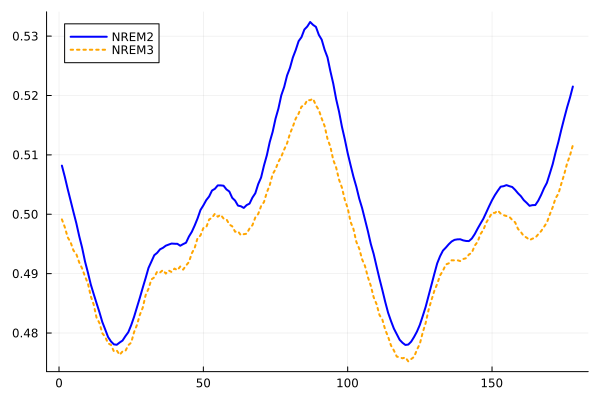

In [231]:
nrem2_mean_scaled = mean(nrem2_scaled, dims=1)[1,:]
nrem2_std_scaled = std(nrem2_scaled, dims=1)[1,:]
nrem3_mean_scaled = mean(nrem3_scaled, dims=1)[1,:]
nrem3_std_scaled = std(nrem3_scaled, dims=1)[1,:]
p1 = plot(nrem2_mean_scaled, label="NREM2", c=:blue, lw=2)
plot!(nrem3_mean_scaled, label="NREM3", c=:orange, lw=2, ls=:dot)

----

# Make Splits

Since our focus is on forecasting, we aren't too concerned with balancing classes. But for good practice, we will use balance the classes using the size of the minority class.

In [232]:
min(size(nrem2_samples, 1), size(nrem3_samples, 1))

68550

This is a lot of training data. While it would be great to use it all, for now we can focus on a smaller random subset. I will do 2500 per class for now. 

In [233]:
nrem2_shuffle_idxs = StatsBase.sample(1:size(nrem2_samples, 1), 2500; replace=false)
nrem3_shuffle_idxs = StatsBase.sample(1:size(nrem3_samples, 1), 2500; replace=false)
nrem2_subset = nrem2_samples[nrem2_shuffle_idxs, :]
nrem3_subset = nrem3_samples[nrem3_shuffle_idxs, :];

In [234]:
X_train = vcat(nrem2_subset, nrem3_subset);
y_train = Int.(vcat(zeros(2500), ones(2500)));

Shuffle the training data (not really necessary since we are doing stochastic GD)

In [235]:
shuffled_train_idxs = Random.shuffle(1:5000);
X_train_final = X_train[shuffled_train_idxs, :]
y_train_final = y_train[shuffled_train_idxs];

In [236]:
X_train = X_train_final
y_train = y_train_final

5000-element Vector{Int64}:
 0
 0
 1
 0
 1
 1
 0
 1
 0
 1
 ⋮
 0
 1
 1
 1
 0
 1
 0
 0
 0

In [237]:
@save "./sleep5000_train.jld2" X_train y_train

#### Test Split

In [238]:
nrem2_idxs = findall(x -> x .== 2, y_test[:, 1]);
nrem3_idxs = findall(x -> x .== 3, y_test[:, 1]);
nrem2_samples = X_test[nrem2_idxs, :];
nrem3_samples = X_test[nrem3_idxs, :];

In [239]:
min(size(nrem2_samples, 1), size(nrem3_samples, 1))

16995

Use 500 test samples per class

In [240]:
nrem2_shuffle_idxs = StatsBase.sample(1:size(nrem2_samples, 1), 500; replace=false)
nrem3_shuffle_idxs = StatsBase.sample(1:size(nrem3_samples, 1), 500; replace=false)
nrem2_subset = nrem2_samples[nrem2_shuffle_idxs, :]
nrem3_subset = nrem3_samples[nrem3_shuffle_idxs, :];

In [241]:
X_test = vcat(nrem2_subset, nrem3_subset);
y_test = Int.(vcat(zeros(500), ones(500)));

In [242]:
shuffled_test_idxs = Random.shuffle(1:1000);
X_test_final = X_test[shuffled_test_idxs, :]
y_test_final = y_test[shuffled_test_idxs];

In [243]:
X_test = X_test_final
y_test = y_test_final

1000-element Vector{Int64}:
 0
 0
 0
 1
 0
 0
 0
 0
 1
 1
 ⋮
 1
 1
 1
 0
 0
 1
 1
 1
 0

In [244]:
@save "./sleep5000_test.jld2" X_test y_test